# Checkpoint 3: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones in CP2. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 29 November 2020** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [147]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [148]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [149]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

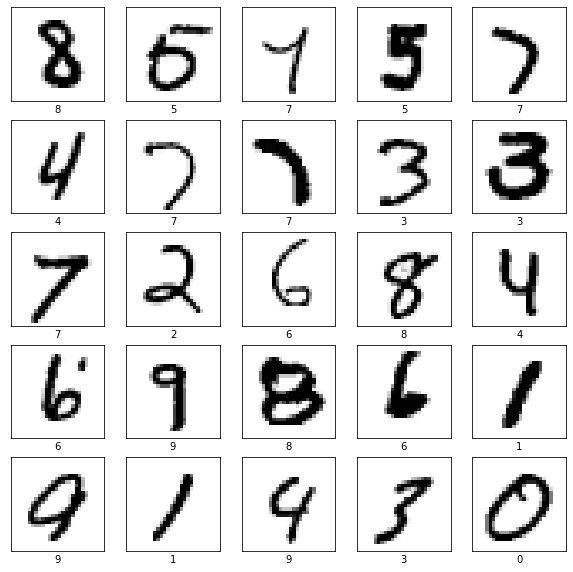

label marks [8 5 7 5 7 4 7 7 3 3 7 2 6 8 4 6 9 8 6 1 9 1 9 3 0]


In [150]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [151]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [152]:
intermediate_dim =256
latent_dim = 2

# Define the encoder

# While convolution isn't needed, I have already created and spent time ensuring the shape is correct and further
# further developing my convolution use and understanding.

# Shape was defined earlier in the program as (28,28,1), which is what we want
i = Input(shape = shape)
x = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')(i)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
e = Flatten()(x)
hidden0 = Dense(intermediate_dim,activation = 'relu')(e)
hidden1 = Dense(intermediate_dim,activation = 'relu')(hidden0)
# z_mean, z_log_var and z layers
z_mean = Dense(latent_dim, name='z_mean')(hidden1)
z_log_var = Dense(latent_dim, name='z_log_var')(hidden1)
z = Lambda(sampling, output_shape=(latent_dim,),name='z')([z_mean,z_log_var])

# Model
encoder = Model(i,[z_mean, z_log_var, z], name='encoder')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 28, 28, 1)    10          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 14, 14, 1)    0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 14, 14, 2)    20          max_pooling2d_4[0][0]            
____________________________________________________________________________________________

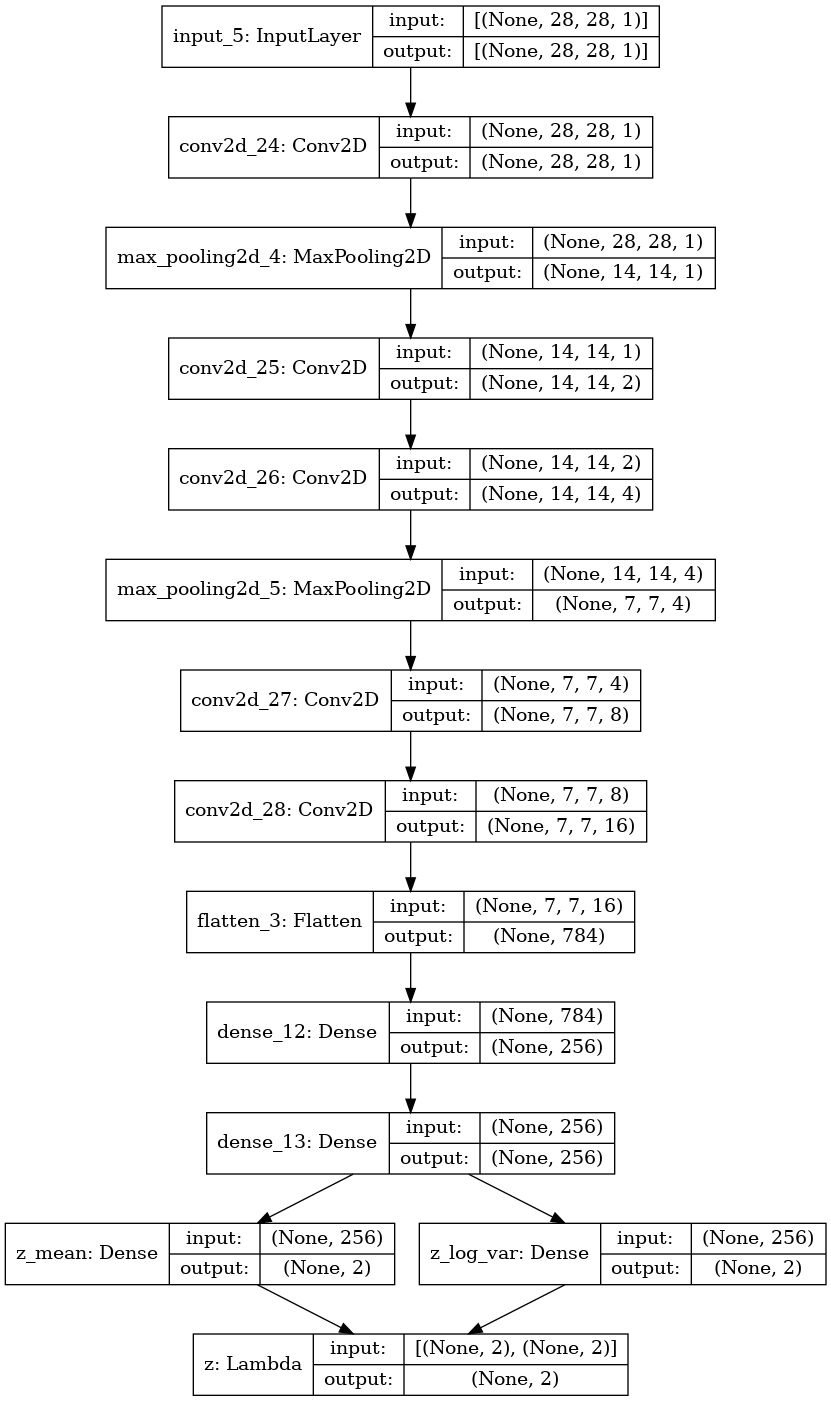

In [153]:
# Visualise the encoder
encoder.summary()
plot_model(encoder,show_shapes = True)

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [154]:
print(np.prod(shape))

784


In [155]:
# Construct the decoder

# latent space of two for input layer, same as latent_dim
dec_i = Input(shape = (latent_dim,))
y = Dense(intermediate_dim,activation = 'relu')(dec_i)
y = Dense(intermediate_dim,activation = 'relu')(y)
# 784 as encoder flatten brings it to 784. maybe introduce another dense layer with 256 nodes
y = Dense(7*7*16,activation = 'relu')(y)
# Reshape. Comes after in the instructions above, which I sort of understand but why not put it here?
y = Reshape((7,7,16))(y)
y = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(y)
y = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(y)
y = UpSampling2D(size = (2,2))(y)
y = Conv2D(4, (3,3), activation = 'relu', padding = 'same')(y)
y = Conv2D(2, (3,3), activation = 'relu', padding = 'same')(y)
y = UpSampling2D(size = (2,2))(y)
o = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(y)

# Model
decoder = Model(dec_i, o, name = 'decoder')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 784)               201488    
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 8)           1160

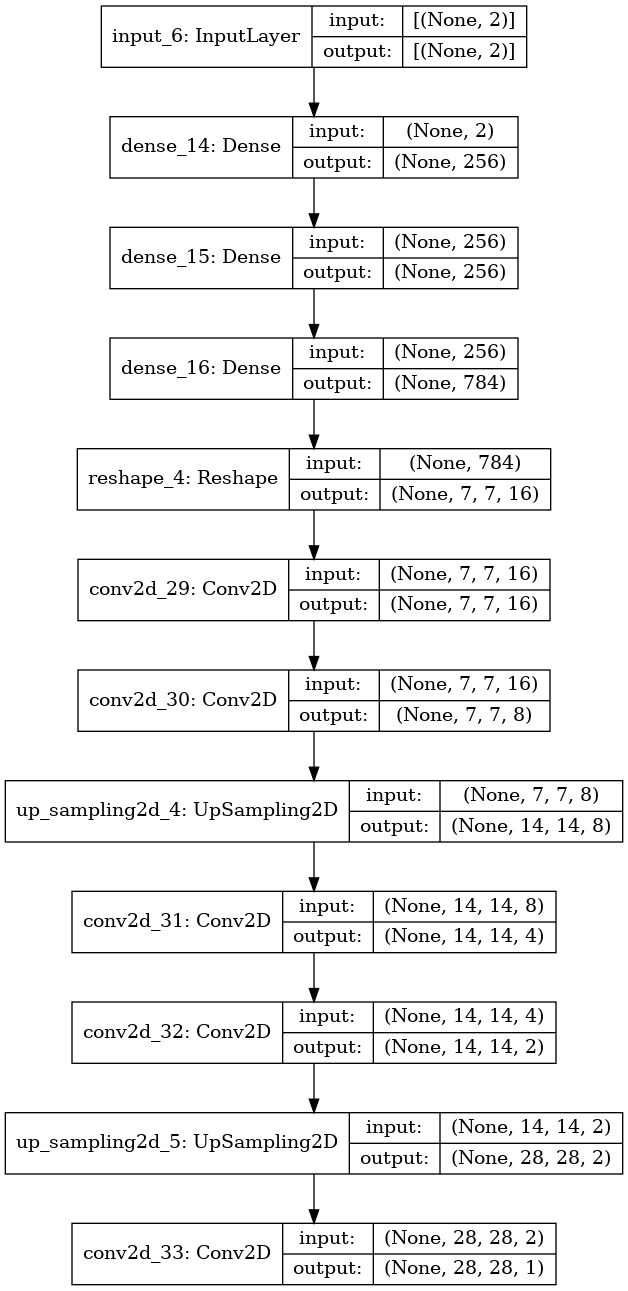

In [156]:
# Visualise the decoder
decoder.summary()
plot_model(decoder,show_shapes = True)

#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 269350    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         271913    
Total params: 541,263
Trainable params: 541,263
Non-trainable params: 0
_________________________________________________________________


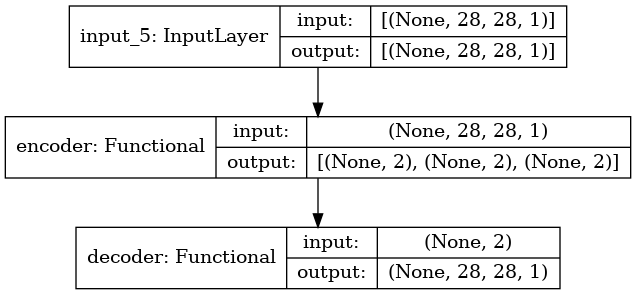

In [157]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

# Construct and show the VAE model
vae = Model(i, o, name='VAE')
vae.summary()
plot_model(vae,show_shapes = True)

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [158]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Compile the model.
* Train for ca. **50 epochs**
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [159]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

# Call the vae model, not really sure what its asking for with 2 latent dimensions
call = compile_vae(vae)

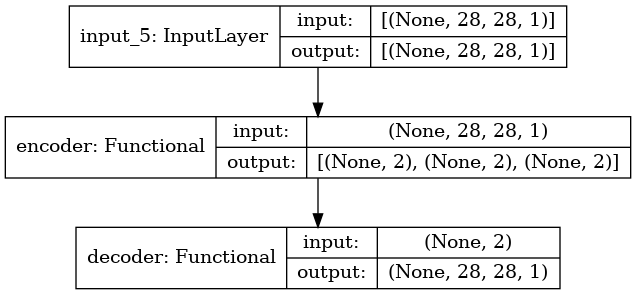

In [160]:
# Plot model
plot_model(vae, show_shapes=True)

<span style="color:blue">
    This is the expected shape I believe. The encoder outputs 3 values, but you only use 1. I think this is correct.
</span>

In [161]:
# Fit the model. Decrease batch size for slower but better results.
# Another way to improve results is allow for more nodes in convoluted layers. But the runtime would be too long to be
# run on the university computers again. Not a good use of time.
vaefit = vae.fit(X_train, X_train, epochs = 50, batch_size = 128, validation_split = 0.2, shuffle = True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 12s 240us/sample - loss: 215.1746 - reco_loss: 213.2475 - kl_loss: 1.9271 - val_loss: 183.3279 - val_reco_loss: 179.6762 - val_kl_loss: 3.6517
Epoch 2/50
48000/48000 [==============================] - 11s 233us/sample - loss: 176.7588 - reco_loss: 172.5961 - kl_loss: 4.1628 - val_loss: 171.4567 - val_reco_loss: 166.9957 - val_kl_loss: 4.4611
Epoch 3/50
48000/48000 [==============================] - 11s 233us/sample - loss: 168.2620 - reco_loss: 163.4654 - kl_loss: 4.7967 - val_loss: 164.8808 - val_reco_loss: 159.8366 - val_kl_loss: 5.0442
Epoch 4/50
48000/48000 [==============================] - 11s 234us/sample - loss: 162.5759 - reco_loss: 157.4174 - kl_loss: 5.1585 - val_loss: 160.3744 - val_reco_loss: 155.3450 - val_kl_loss: 5.0294
Epoch 5/50
48000/48000 [==============================] - 11s 234us/sample - loss: 159.0141 - reco_loss: 153.6712 - kl_loss: 5.3430 - val_loss: 15

48000/48000 [==============================] - 11s 235us/sample - loss: 140.0463 - reco_loss: 133.3171 - kl_loss: 6.7293 - val_loss: 140.4700 - val_reco_loss: 133.6768 - val_kl_loss: 6.7932
Epoch 42/50
48000/48000 [==============================] - 11s 239us/sample - loss: 139.7480 - reco_loss: 132.9930 - kl_loss: 6.7550 - val_loss: 140.3255 - val_reco_loss: 133.7618 - val_kl_loss: 6.5637
Epoch 43/50
48000/48000 [==============================] - 11s 235us/sample - loss: 139.5087 - reco_loss: 132.7520 - kl_loss: 6.7567 - val_loss: 140.6167 - val_reco_loss: 133.7933 - val_kl_loss: 6.8234
Epoch 44/50
48000/48000 [==============================] - 11s 230us/sample - loss: 139.7299 - reco_loss: 132.9625 - kl_loss: 6.7675 - val_loss: 140.3358 - val_reco_loss: 133.3665 - val_kl_loss: 6.9693
Epoch 45/50
48000/48000 [==============================] - 12s 240us/sample - loss: 139.6945 - reco_loss: 132.9029 - kl_loss: 6.7915 - val_loss: 140.4133 - val_reco_loss: 133.7747 - val_kl_loss: 6.6387
Ep

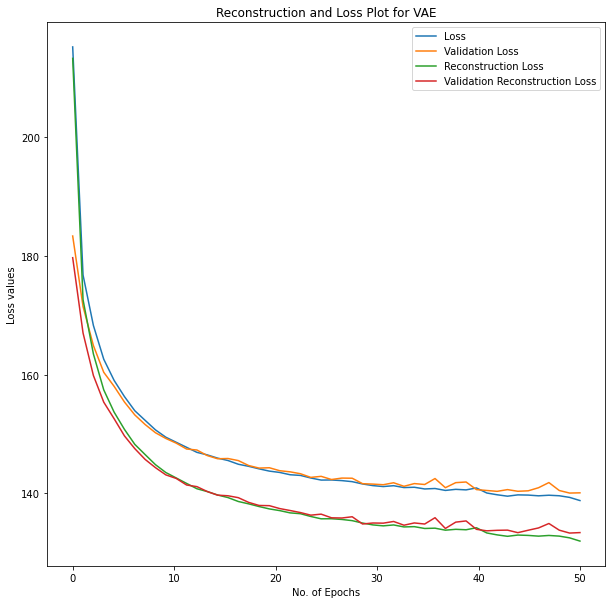

In [162]:
epochs = np.linspace(0,50,50)
plt.figure(figsize=(10,10))
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Reconstruction and Loss Plot for VAE")
plt.plot(epochs,vaefit.history['loss'], label = 'Loss')
plt.plot(epochs,vaefit.history['val_loss'], label = 'Validation Loss')
plt.plot(epochs,vaefit.history['reco_loss'], label = 'Reconstruction Loss')
plt.plot(epochs,vaefit.history['val_reco_loss'], label = 'Validation Reconstruction Loss')
plt.legend()
plt.show()

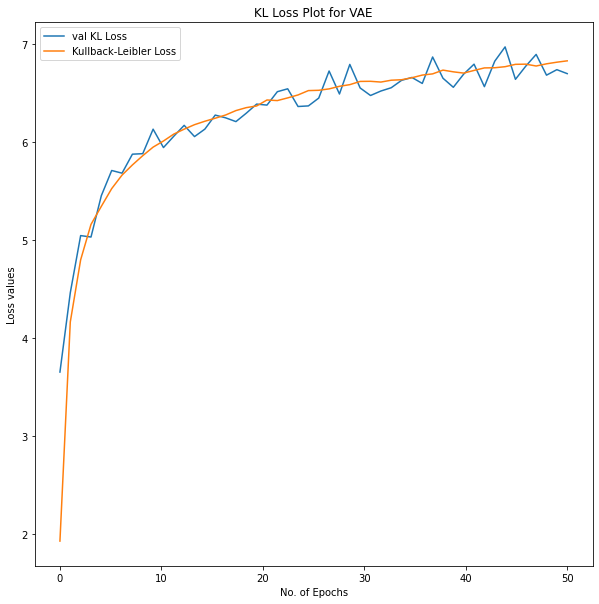

In [163]:
epochs = np.linspace(0,50,50)
plt.figure(figsize=(10,10))
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("KL Loss Plot for VAE")
plt.plot(epochs,vaefit.history['val_kl_loss'], label = 'val KL Loss')
plt.plot(epochs,vaefit.history['kl_loss'], label = 'Kullback-Leibler Loss')
plt.legend()
plt.show()

<span style="color:blue">
    High loss and reconstruction loss, but it flattens out over over time at around 140 (at least for my run).
    The KL loss increases lightly but also levels out.
</span>

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

In [164]:
# predicting images into the laten space
laten_pred = encoder.predict(X_test)

/opt/anaconda-2021.05/envs/daml/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [165]:
print(len(laten_pred), laten_pred[0].shape, laten_pred[1].shape, laten_pred[2].shape)
# laten_pred spits out a list of 3
# each has (10000, 2) array. These are for z_mean, z_log_var and z
# We'll look at z_mean, which is laten_pred[0]

# Gives XY
print(laten_pred[0][0])


print(y_test.shape)

3 (10000, 2) (10000, 2) (10000, 2)
[-0.5357303  0.3556758]
(10000,)


/tmp/ipykernel_172945/939631299.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


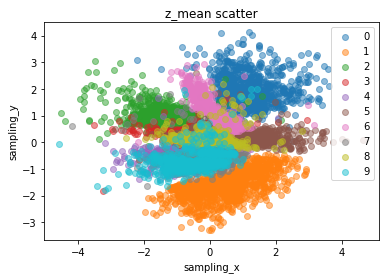

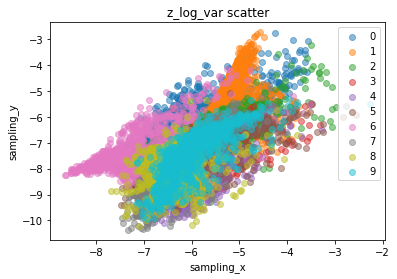

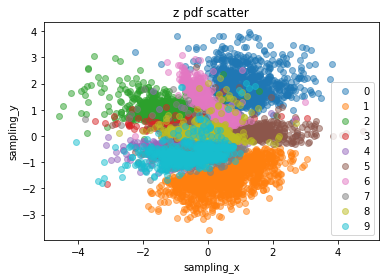

In [166]:
# Create scatter plot

# features to plot. From sampling which is what forms z. Need to ask, what this is about.
featx = 'sampling_x'
featy = 'sampling_y'
title = ['z_mean scatter', 'z_log_var scatter', 'z pdf scatter']

# Set up empty array
new_laten = []

# Create figure and axis objects


for l in range(len(laten_pred)):
    
    fig, ax = plt.subplots()
    for i in range(nb_classes):
        # Mask - makes true or false dependent on label. So all 0's are true everything else false, then for 1's, 2's, etc.
        mask = y_test == i

        # Create array for which only mask elements of z_mean are saved
        new_laten_pred = laten_pred[l][mask]
        # Plot these elements on a scatter, with equivalent label for the class
        ax.scatter([x[0] for x in new_laten_pred],[x[1] for x in new_laten_pred], label = i, alpha = 0.5)

    ax.set_title(title[l])
    ax.legend()
    ax.set_xlabel(featx)
    ax.set_ylabel(featy)    
    fig.show()            


<span style="color:blue">
    While all of the digits overlap somewhat (we're looking mostly at the PDF which appears identical to mean), they have distinct 'areas' for which they occupy on each of the graphs. Some are clearly separated (such as 1 and 0) and some are overlapped (such as 9 and 4), due to some similarity between some of the digits when they're drawn. For example, in the plots below which show some true images and then their predictions from the VAE, we can see that there are similarities in the characteristics of lets say, 9 and 4 or 2 and 3, and the VAE isn't perfect at distinguishing these characteristics for the two separate digits meaning that there is some overlap between these groups for which the network couldn't determine whether an image was a 9 or a 4.
</span>    
    


<span style="color:blue">   
With more training (and possibly a better network), I'm sure these overlapping sections that are produced by this confusion would be minimised, but I'm unsure whether or not they can be entirely eliminated.
</span>

In [167]:
# Autoencoder predicting the X_test (digit) images
digit_pred = vae.predict(X_test)

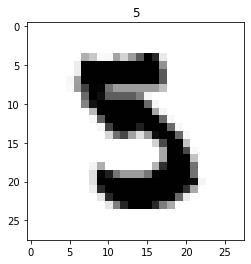

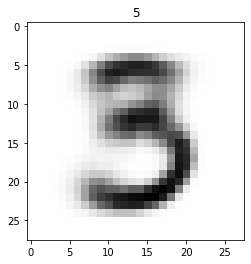

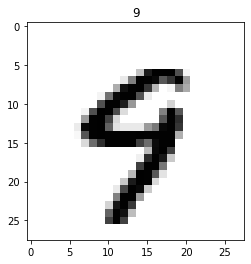

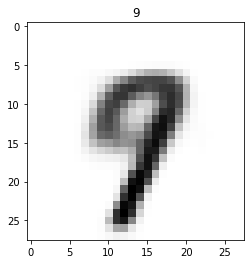

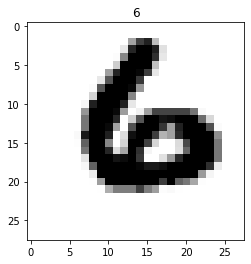

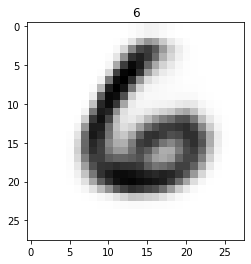

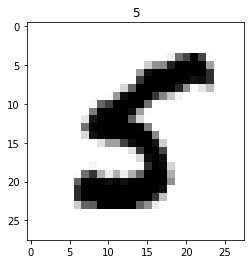

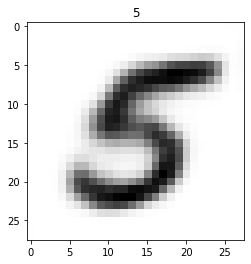

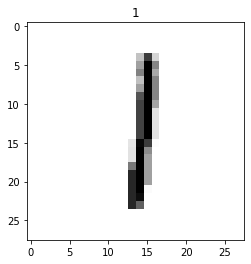

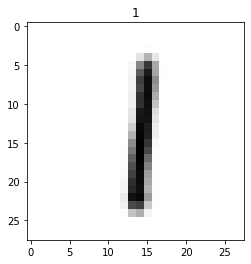

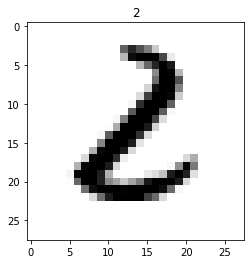

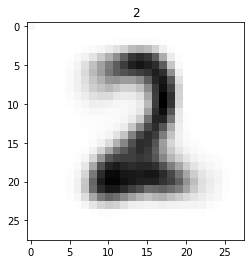

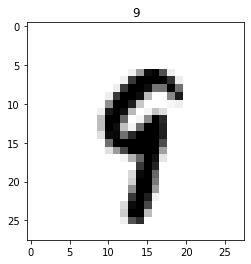

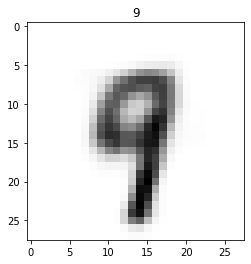

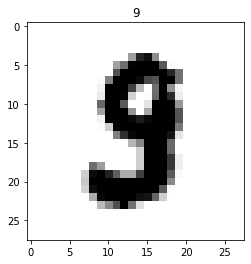

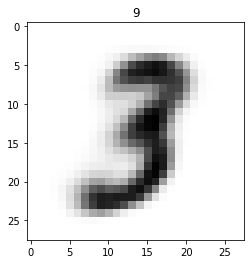

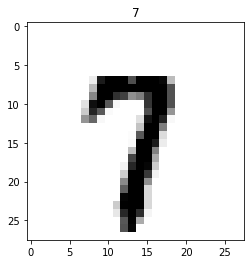

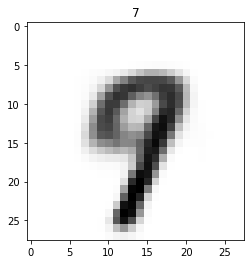

In [168]:
# Plot predictions, just for curiosity.
for i in range(9):
    # Shows true image
    plt.imshow(X_test[i],cmap=plt.cm.binary)
    # Collects its correct label
    plt.title(int(y_test[i]))
    plt.show()
    
    # Show reproduced image
    plt.imshow(digit_pred[i], cmap=plt.cm.binary)
    plt.title(int(y_test[i]))
    plt.show()

#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

(100, 2)


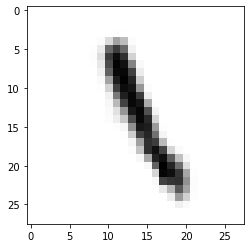

In [170]:
# Create a 10 point linspace between 3 and -3
spaced_setx = np.linspace(-3,3,10)
spaced_sety = np.linspace(-3,3,10)

# Grid of pairs of coordinates
mesh_setx, mesh_sety = np.meshgrid(spaced_setx, spaced_sety)

# Take the two flattened arrays, and reshape to (100,1)
flat_meshx = mesh_setx.flatten().reshape((100,1))
flat_meshy = mesh_sety.flatten().reshape((100,1))

# Then stack to apply x component to y component
sqarray = np.hstack((flat_meshx, flat_meshy))
print(sqarray.shape)

# Use the decoder to predict the output for our sqarray (spanning latent space)
decode_pred = decoder.predict(sqarray)
# Plot just to test that it works as expected (we get a result)
plt.imshow(decode_pred[0], cmap=plt.cm.binary)

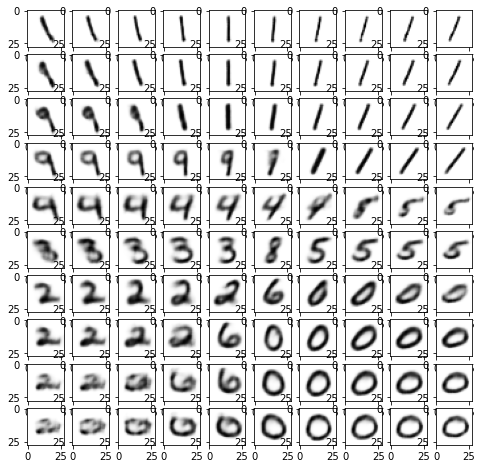

In [171]:
# Plot the decode predict latent space results
fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    # i-1 as subplot requires non-zero value for i
    plt.imshow(decode_pred[i-1], cmap=plt.cm.binary)
plt.show()

<span style="color:blue">
    You can see from our latent space the different predictions and how some values can be confused for others within it. Along the y axis in certain cases you can see values morphing from one value into another (4 into 6, 9 into 1, 6 into 0) but there are some cases for which the values are consistent (0, 1). 
</span>

<span style="color:blue">
This can be understood on the latent space pdf plot (shown above) as there are very distinct and separate areas for 0 and 1 along the x and y axis' that we are plotting across, but in between there is a lot of overlapping between different digits, which explains the 'morphing' as the predictor isn't sure whether to draw a 6 or a 4 when at a certain point within the latent space for which these two digit groups overlap. (Our above created (100,2) array spans the latent space on the pdf plot like a grid, predicting images with respect to the specific point in latent space that it represents, whether that be an area that features the characteristics of 0, or any other value)
</span>

<span style="color:blue">
    From this, we can see that using the VAEs we are able to generate images that look (somewhat) like the original images they are produced from. For areas within the latent space in which a lot of overlapping occurs the decoder cannot predict our images perfectly and so you get fun numbers that look like both 4 and 6.
</span>

# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [172]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.python.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?
    
---

<span style="color:blue">
    
    
- The discriminator model tries to determine whether or not images that are fed to it are real or fake, and spits out a likelihood for this.
    
- A sequential model is one in which each layer has one input and one output (according to the keras documentation). The model we're looking at here uses convolution, LeakyReLU activation, and then Dropout applied to the original image. It applies this twice before it flattens and gives out the sigmoid result from a dense layer that we consider as the 'true, false' result.
    
- LeakyReLU is similar to ReLU but has a small slope for negative values rather than a flat slope. This is to deal with situations in which certain nodes may 'die' with normal ReLU (situations in which the nodes arent active, they are given a small positive gradient in the negative rather than killing them with a flat gradient). Dropout layers are layers in which the input to a node is just 'dropped'. This means at random setting inputs to zero, which adds variance to the system and 'regularises' it, decreasing overfitting.
    
- The discriminator produces true or false for the images, which is a binary result. Therefore, binary cross entropy is the appropriate loss function for our model.
</span>

In [87]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0

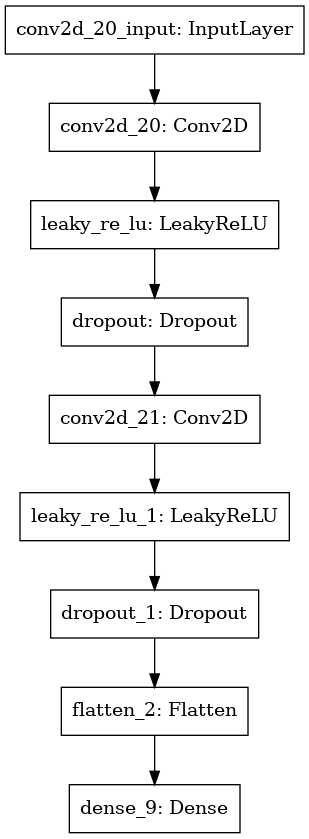

In [88]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?
    
---

<span style="color:blue">
      
- The input to the generator model is the nodes respective to a 7x7x128 image, with the size of the latent dimensions passed to it. This is (in the words of the documentation given) a point (or points) in latent space which will be used to generate fake images with the same shape as our initial samples. Initially this latent space will be filled with random variables.
    
- The Conv2DTranspose layer is used to quadruple the area of the input feature maps. It is initially in a (7,7) shape and needs to be upsamples to (14,14), then (28,28). This can be seen by the kernel size dimensions (4,4) with the same padding which will increase its shape.
    
- This is because for each pixel's data is defined as 'pixel intensities' which are held between (0,1) so it requires a sigmoid function to produce the results between 0 and 1
</span>

In [135]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 128)      

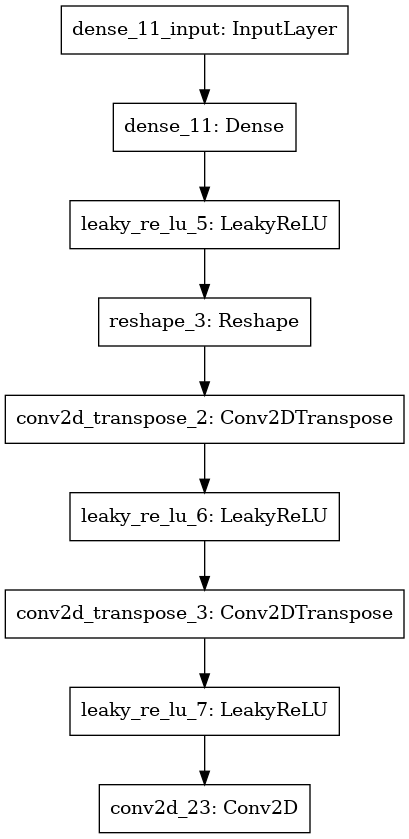

In [136]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.
    
---

<span style="color:blue">
      
- The order of the sequence appears to be that the generator model is attached first, and then the discriminator is applied second. So the input is first into the generative model with a latent space of points. From there the model generates fake images that are fed to the discriminator. The discriminator then tries to determine if the image is fake or not. This is assuming that the generator and discriminator are trained such that the discriminator knows what should be real and fake based on real samples beforehand, and therefore this allows us to better train the generator by trying to make the discriminator recognise the fake images as more and more 'real' by improving the generator training.
    
- The generator model only cares about the discriminators results on the fake images, and only wants it to be trained in a standalone manner with examples of real and fake images, separate from the generator. Therefore, when the generator model is applied to the discriminator, the discriminator is told not to be trainable as you dont want it to overfit on the fake generator data.
</span>

In [137]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


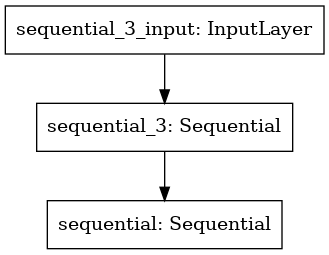

In [138]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for barch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?
    
---

<span style="color:blue">
- It selects random images from a list of samples, and are used to develop a training set for the discriminator (which takes real and fake images).
- Labels the samples as 'real' (label as 1).
</span>

In [139]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

In [140]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

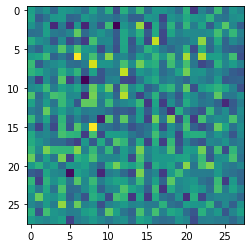

In [141]:
A, b = generate_fake_samples(g_model, latent_dim, 1000)

plt.imshow(A[0])

<span style="color:blue">
The generator is not yet trained, so the result is really messy! This is to be expected, as it appears random.
</span>

---
Some functions for saving GAN models and output images

In [142]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

---
<span style="color:blue">
Stepping through j:
    
   You get real samples, and make fake samples from the generator model. Then create a training set for the discriminator using the fake and real samples. You then 'train' the discriminator on this data to get its weights (this training doesnt affect the standalone discriminator model) and generate latent_points for the generator, create inverted 'real' labels for the fake samples that will be passed to the generator and then update/train the generator based on the error produced by the discriminator. 
</span>

In [143]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [144]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=2)

>1, 1/234, d=12.266, g=0.000
>1, 2/234, d=6.715, g=0.264
>1, 3/234, d=1.224, g=8.569
>1, 4/234, d=0.313, g=12.690
>1, 5/234, d=0.563, g=12.268
>1, 6/234, d=0.244, g=10.955
>1, 7/234, d=0.170, g=9.496
>1, 8/234, d=0.063, g=8.130
>1, 9/234, d=0.044, g=6.924
>1, 10/234, d=0.036, g=5.119
>1, 11/234, d=0.067, g=3.882
>1, 12/234, d=0.170, g=3.825
>1, 13/234, d=0.185, g=4.531
>1, 14/234, d=0.094, g=4.958
>1, 15/234, d=0.070, g=5.316
>1, 16/234, d=0.071, g=5.516
>1, 17/234, d=0.053, g=5.655
>1, 18/234, d=0.056, g=5.710
>1, 19/234, d=0.055, g=5.419
>1, 20/234, d=0.051, g=5.344
>1, 21/234, d=0.043, g=5.310
>1, 22/234, d=0.040, g=5.215
>1, 23/234, d=0.033, g=5.069
>1, 24/234, d=0.034, g=5.032
>1, 25/234, d=0.037, g=4.734
>1, 26/234, d=0.034, g=4.707
>1, 27/234, d=0.047, g=4.718
>1, 28/234, d=0.052, g=4.631
>1, 29/234, d=0.027, g=4.582
>1, 30/234, d=0.036, g=4.423
>1, 31/234, d=0.043, g=4.347
>1, 32/234, d=0.056, g=4.189
>1, 33/234, d=0.046, g=4.199
>1, 34/234, d=0.059, g=3.873
>1, 35/234, d=0.087

>2, 46/234, d=0.016, g=4.214
>2, 47/234, d=0.018, g=4.250
>2, 48/234, d=0.020, g=4.226
>2, 49/234, d=0.016, g=4.248
>2, 50/234, d=0.013, g=4.295
>2, 51/234, d=0.017, g=4.295
>2, 52/234, d=0.020, g=4.278
>2, 53/234, d=0.016, g=4.266
>2, 54/234, d=0.012, g=4.365
>2, 55/234, d=0.018, g=4.284
>2, 56/234, d=0.023, g=4.242
>2, 57/234, d=0.018, g=4.285
>2, 58/234, d=0.013, g=4.295
>2, 59/234, d=0.016, g=4.283
>2, 60/234, d=0.017, g=4.287
>2, 61/234, d=0.016, g=4.275
>2, 62/234, d=0.014, g=4.274
>2, 63/234, d=0.014, g=4.299
>2, 64/234, d=0.013, g=4.335
>2, 65/234, d=0.014, g=4.308
>2, 66/234, d=0.019, g=4.328
>2, 67/234, d=0.012, g=4.305
>2, 68/234, d=0.011, g=4.374
>2, 69/234, d=0.014, g=4.389
>2, 70/234, d=0.013, g=4.380
>2, 71/234, d=0.012, g=4.428
>2, 72/234, d=0.013, g=4.440
>2, 73/234, d=0.017, g=4.405
>2, 74/234, d=0.016, g=4.410
>2, 75/234, d=0.013, g=4.386
>2, 76/234, d=0.015, g=4.381
>2, 77/234, d=0.020, g=4.386
>2, 78/234, d=0.013, g=4.370
>2, 79/234, d=0.014, g=4.388
>2, 80/234, d=

<span style="color:blue">
- The loss for the discriminator appears to decrease over time as the loss for the generator grows, and at some threshold they 'flip' with the discriminator loss increasing significantly and the generator loss decreasing significantly. Then the original trend occurs again (d goes down, g goes up) and the flip is repeated. This is why it is labelled as an adverserial network, as the two values 'fight' to have the owest lostt
    
    
- It is possible for the d to start so low that the program doesnt get anywhere, as d and g start low. This is possible but unlikely and didnt happen in my run.
</span>

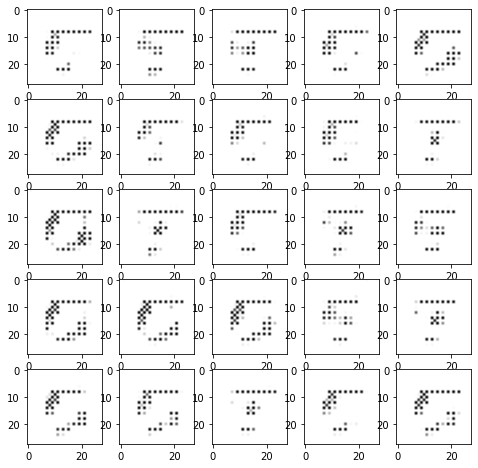

In [146]:
# Generate some images
n_samples = 100
# Predict with gan_model using sqarray from before.
gm_pred = g_model.predict(generate_latent_points(latent_dim, n_samples))

# Plot the decode predict latent space results
fig = plt.figure(figsize=(8, 8))
column = 5
row = 5
for q in range(1, column*row+1):
    fig.add_subplot(row, column, q)
    # i-1 as subplot requires non-zero value for i
    plt.imshow(gm_pred[q-1], cmap=plt.cm.binary)
plt.show()

<span style="color:blue">
- The constructed images by the generator are really messy. but are clearly no longer random. So we can see that the expected behaviour is demonstrated by this.
</span>